In [4]:
# 魔术指令，自动加载模块
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/beihang/xihu/HZTourism/FlowPred-dev")
import os
os.chdir("/home/beihang/xihu/HZTourism/FlowPred-dev")
# import pandas as pd
# from Loss.PearsonMSELoss import pearson_mse_loss_xgb_test
# from utils.utils_data import interactive_plot_comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def get_groups(base_dir, dir_name, pred_len):
    df_mode0 = pd.read_csv(f"{base_dir}/0/{dir_name}/result.csv")
    df_mode1 = pd.read_csv(f"{base_dir}/1/{dir_name}/result.csv")
    df_mode0["time"] = pd.to_datetime(df_mode0["time"])
    df_mode1["time"] = pd.to_datetime(df_mode1["time"])
    df_mode0.sort_values(by="time", inplace=True)
    df_mode1.sort_values(by="time", inplace=True)
    df_mode0_far = df_mode0[(df_mode0.index + 1) % pred_len == 0]
    df_mode1_far = df_mode1[(df_mode1.index + 1) % pred_len == 0]
    df_mode = pd.concat([df_mode0_far, df_mode1_far], ignore_index=True)
    df_mode = df_mode.sort_values(by="time")
    groups_mode = list(df_mode.groupby(df_mode["time"].dt.date))
    return groups_mode


def get_loss(*groups_mode):
    loss_list = []
    # 对于每一个groups_mode, 计算loss
    for groups in groups_mode:
        loss_temp = []
        for date, group in groups:
            loss_temp.append(
                pearson_mse_loss_xgb_test(group["pred"].values, group["real"].values)
            )
        loss_list.append(loss_temp)
    return loss_list

In [22]:
# 获取单个预测结果的预测处理
def get_df_single_mode(res_path, prediction_selection="last", pred_len=72):
    df = pd.read_csv(res_path)
    df["time"] = pd.to_datetime(df["time"])
    df.sort_values(by="time", inplace=True)
    if prediction_selection == "last":
        # 按时间分组，选取每组的最后一次预测
        # df_temp = df.groupby("time").last().reset_index()
        df_temp = df[(df.index+1) % pred_len == 0]
    elif prediction_selection == "first":
        # 按时间分组，选取每组的第一次预测
        # df_temp = df.groupby("time").first().reset_index()
        df_temp = df[(df.index) % pred_len == 0]
    else:
        assert prediction_selection in ["first", "last"], f"prediction_selection 必须是 'first' 或 'last'，但传入的值是 {prediction_selection}"
    df_res = df_temp.sort_values(by="time")
    return df_res

# 获取多个预测结果路径，使用get_df_single_mode进行处理，最终融合成一个df
def get_groups_merge_mutli_df_pred_res(*res_paths, prediction_selection="last", pred_len=72):
    df_list = []
    for res_path in res_paths:
        # print(res_path)
        df = get_df_single_mode(res_path, prediction_selection, pred_len)
        df_list.append(df)
    # 合并所有 DataFrame
    df_merged = pd.concat(df_list, ignore_index=True)
    df_merged = df_merged.drop_duplicates(subset='time')
    df_merged = df_merged.sort_values(by='time')
    groups_merged = list(df_merged.groupby(df_merged["time"].dt.date))
    return groups_merged

# 获得处理的分组
def get_groups_single_mode(res_path, prediction_selection="last", pred_len=72):
    df_res = get_df_single_mode(res_path, prediction_selection, pred_len)
    groups_mode = list(df_res.groupby(df_res["time"].dt.date))
    return groups_mode

def view_res(res_path):
    groups = get_groups_single_mode(res_path)
    args = [groups]
    loss_list = get_loss(*args)
    group_labels = ["pred"]
    interactive_plot_comparison(group_labels, loss_list, *args)
def view_res_multi(*res_paths):
    groups = get_groups_merge_mutli_df_pred_res(*res_paths)
    args = [groups]
    loss_list = get_loss(*args)
    group_labels = ["pred"]
    interactive_plot_comparison(group_labels, loss_list, *args)


# 6小时预测默认参数

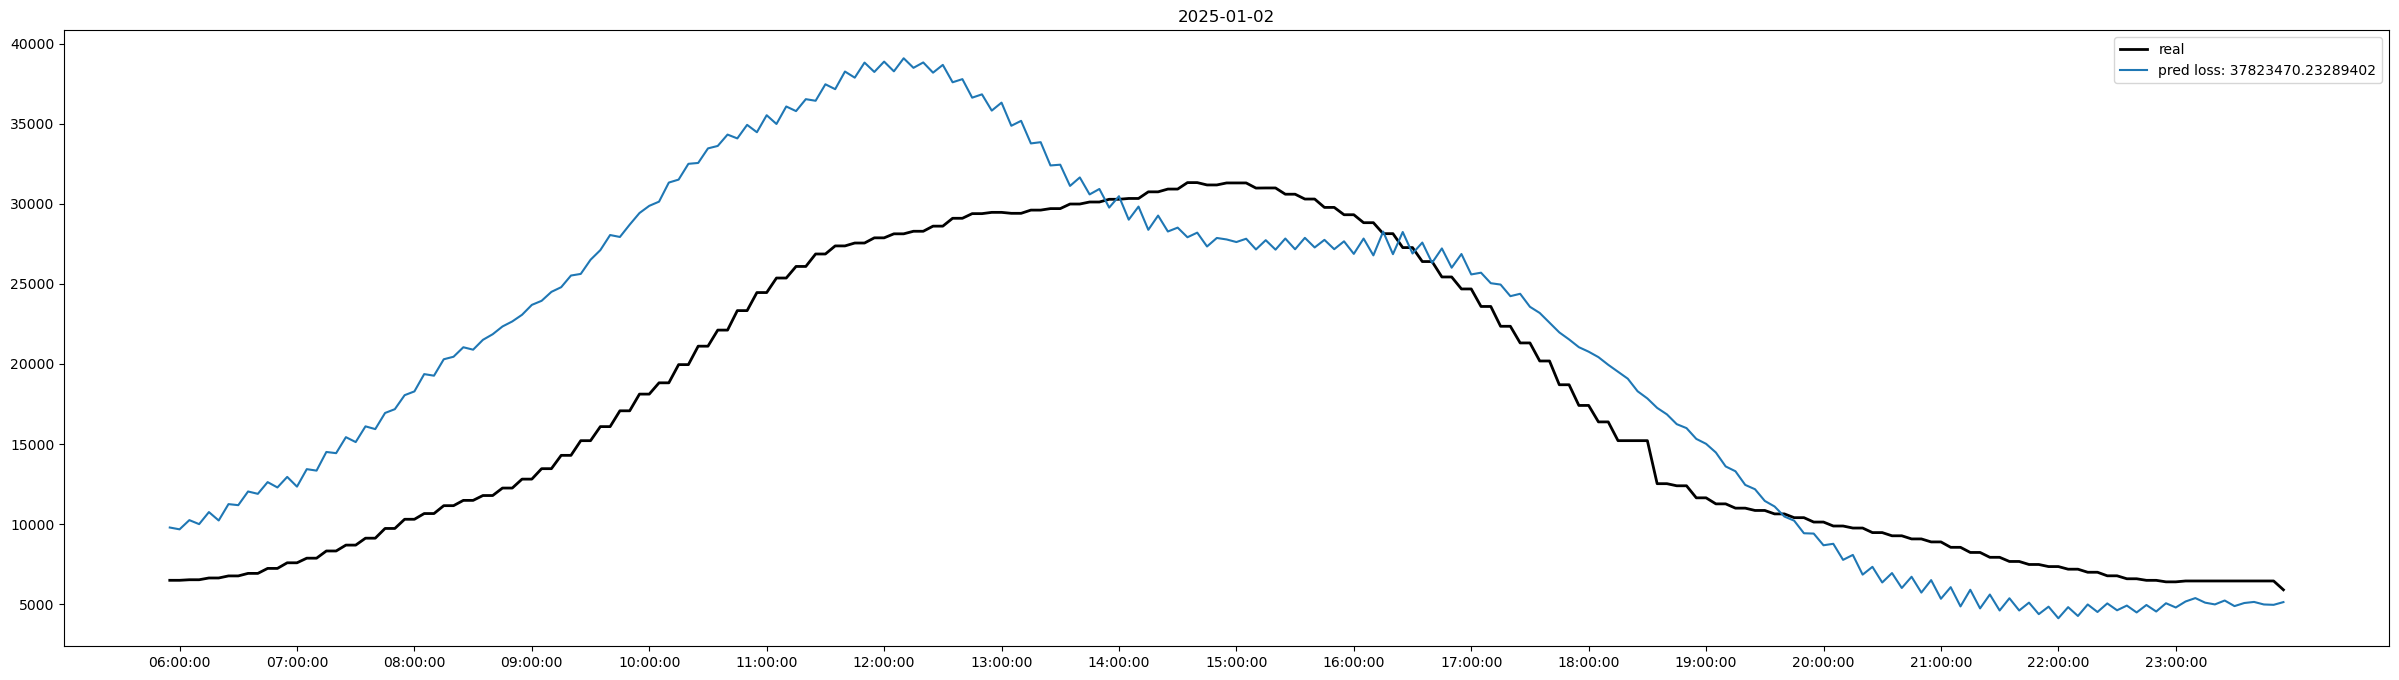

In [23]:
from utils.utils_data import interactive_plot_comparison

base_dir = "data/pred_6h_args_huber_loss/res/res_test/14100/288_72"
dir_name = "Flow_Koopa_Koopa_Flow_ftS_sl288_pl72_segl48_dyna128_h64_l2_nb3_a0.2_test_0"
pred_len = 72
groups_pred_6h = get_groups(base_dir, dir_name,72)
args = [groups_pred_6h]
loss_list = get_loss(*args)
group_labels = ["pred"]
interactive_plot_comparison(group_labels, loss_list, *args)

# 6小时预测调参实验最优参数

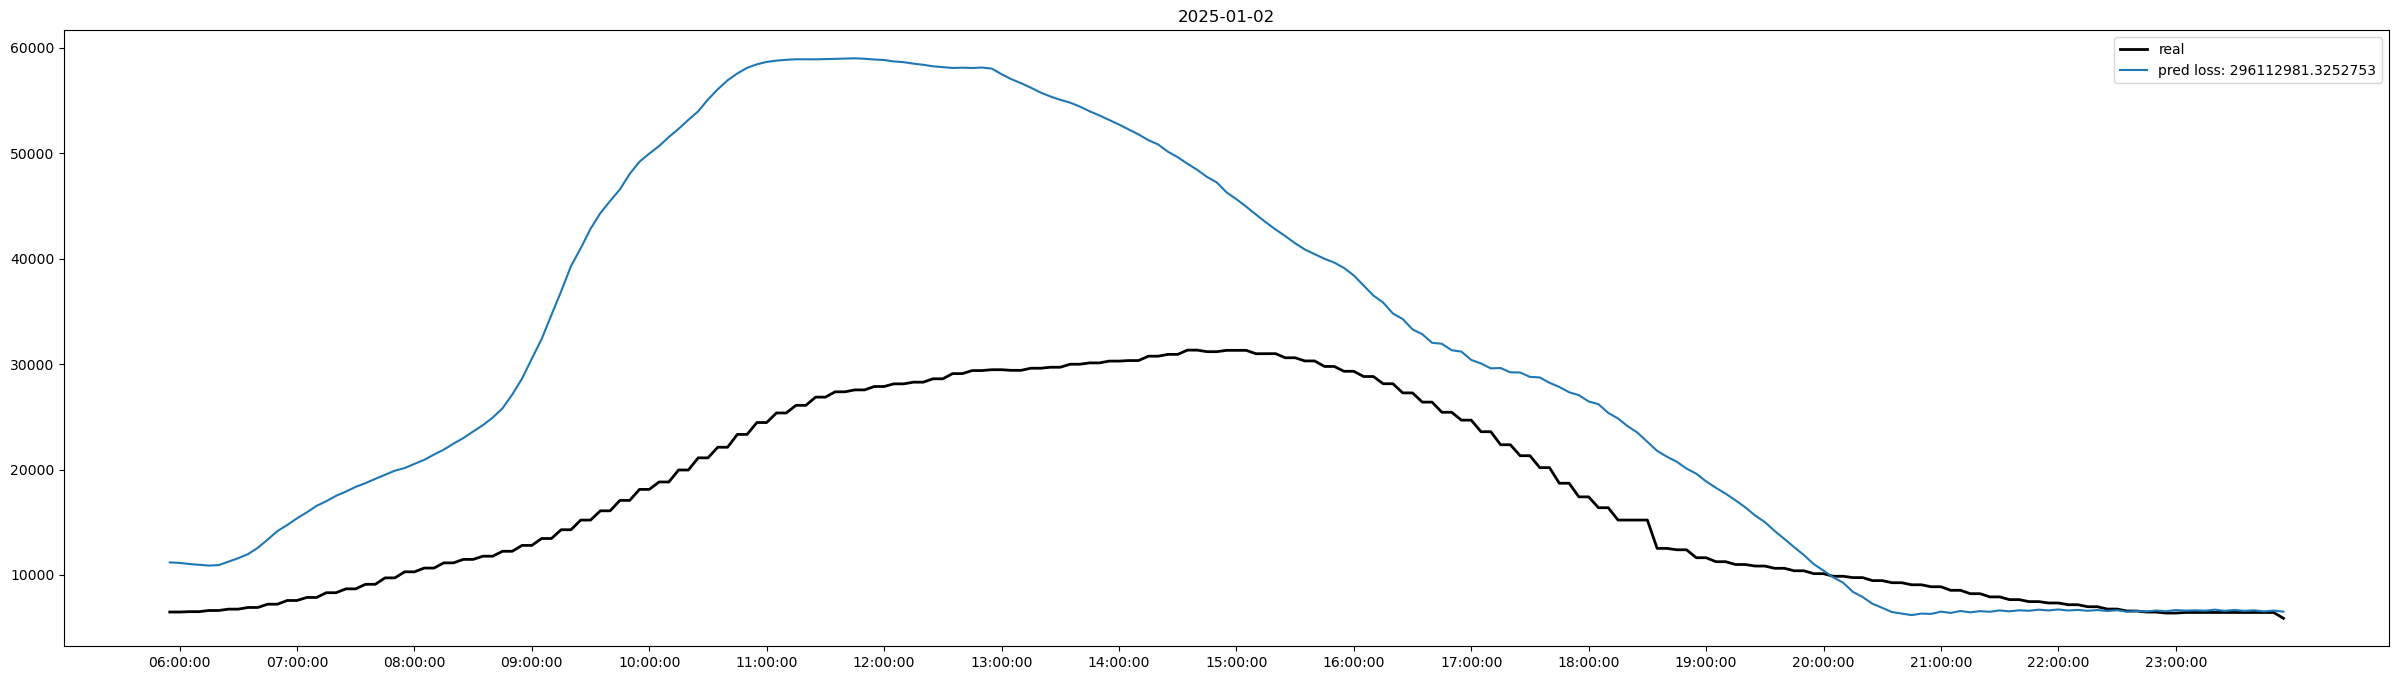

In [7]:
from src.utils.utils_data import view_res_multi

res_paths = ["exper_data/archive/pred_6h_args_huber_loss/res/res_test/14100/288_72/1/Flow_Koopa_Koopa_Flow_ftS_sl288_pl72_segl48_dyna256_h256_l4_nb2_a0.4_test_0/result.csv","exper_data/archive/pred_6h_args_huber_loss/res/res_test/14100/288_72/0/Flow_Koopa_Koopa_Flow_ftS_sl288_pl72_segl48_dyna128_h512_l3_nb2_a0.1_test_0/result.csv"]
view_res_multi(*res_paths)

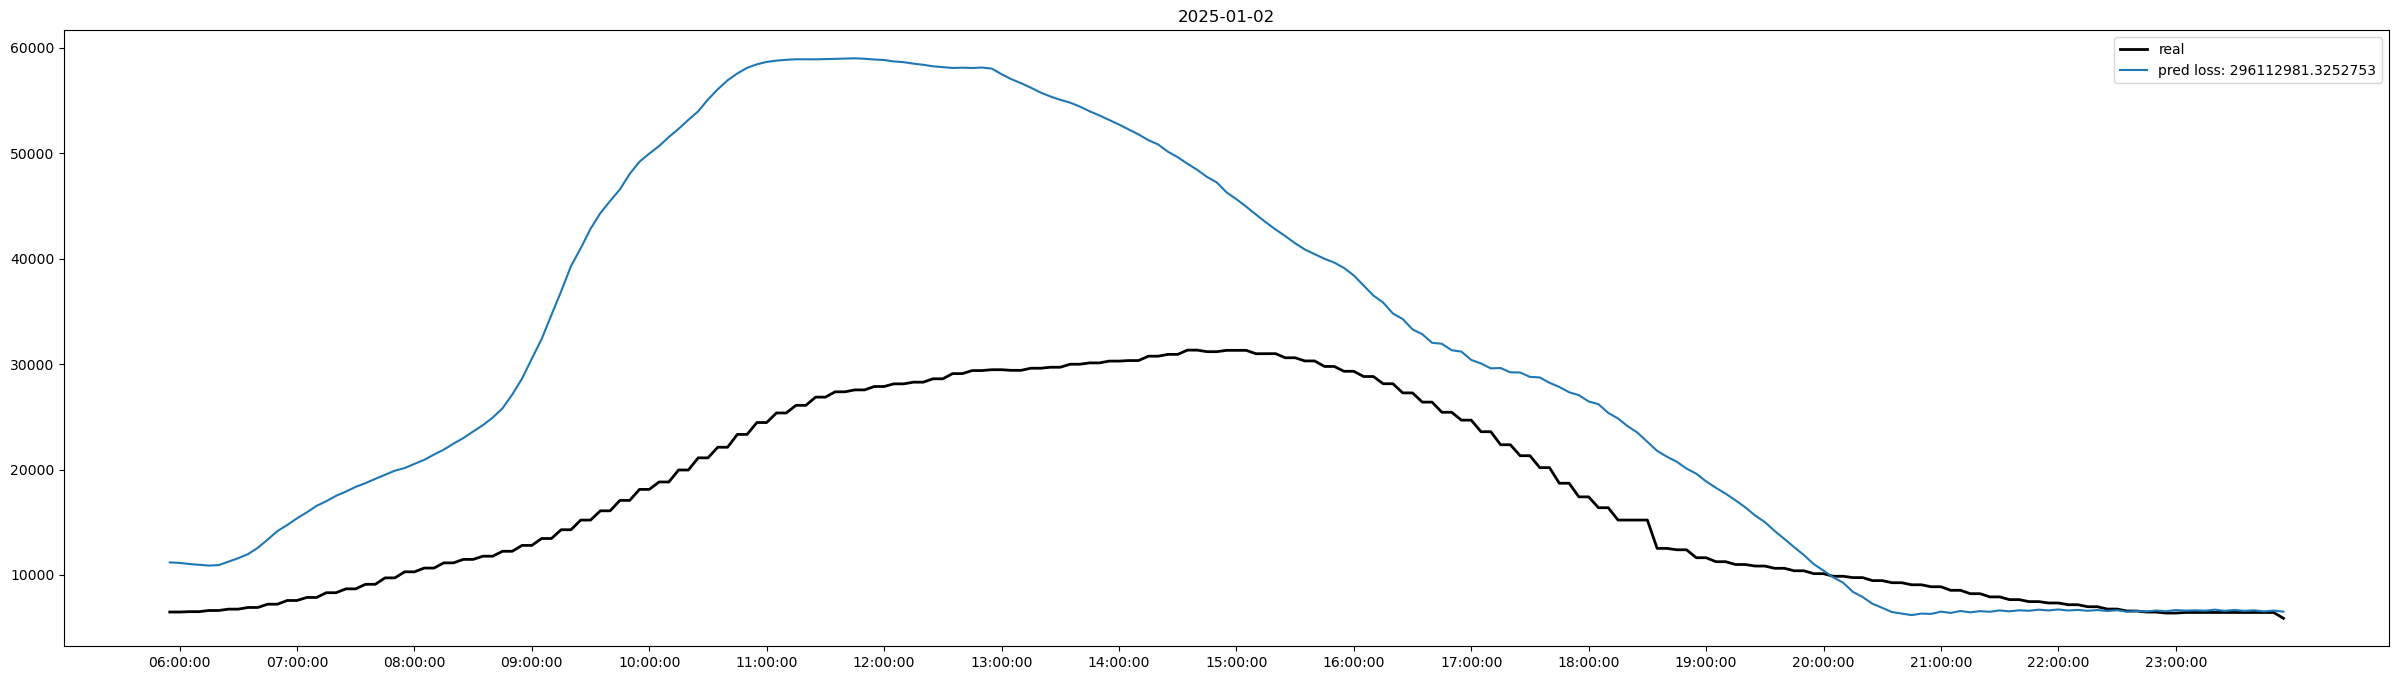

In [25]:
# 工作日
res_path = "data/pred_6h_args_huber_loss/res/res_test/14100/288_72/1/Flow_Koopa_Koopa_Flow_ftS_sl288_pl72_segl48_dyna256_h256_l4_nb2_a0.4_test_0/result.csv"
view_res(res_path)

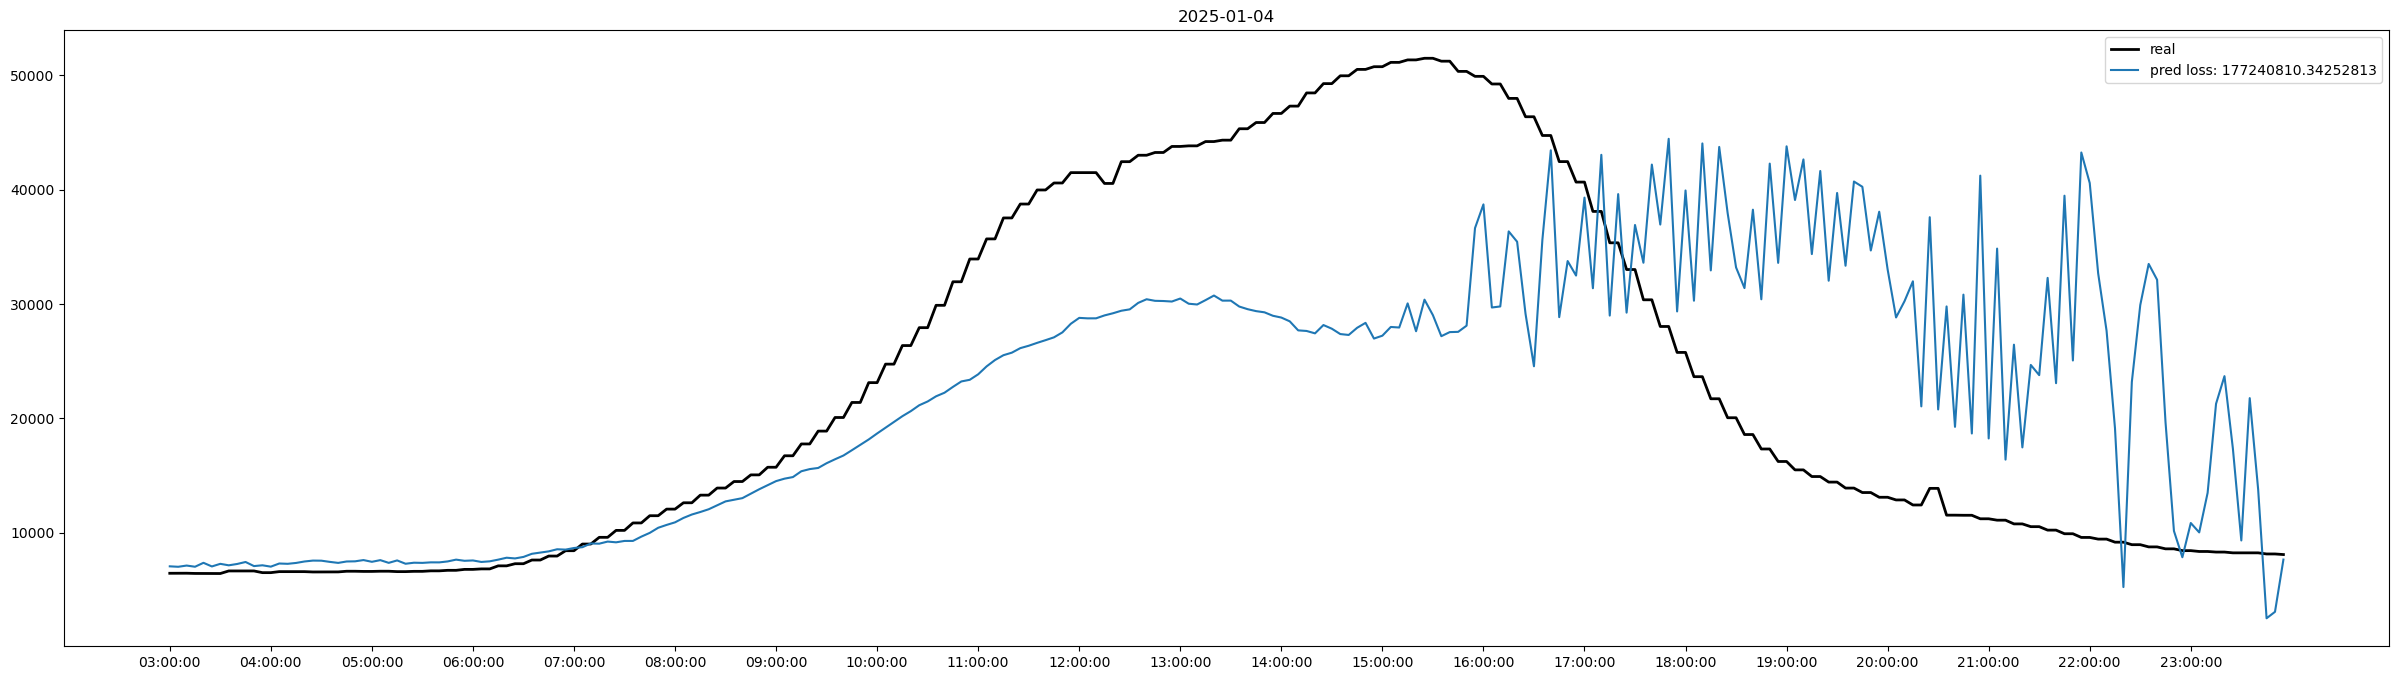

In [26]:
# 节假日
res_path = "data/pred_6h_args_huber_loss/res/res_test/14100/288_72/0/Flow_Koopa_Koopa_Flow_ftS_sl288_pl72_segl48_dyna128_h512_l3_nb2_a0.1_test_0/result.csv"
view_res(res_path)

In [27]:
# 拼接函数
